
Final parameters:  [10.0, 15.0, 0] 
 -> 0.0058685048127897895


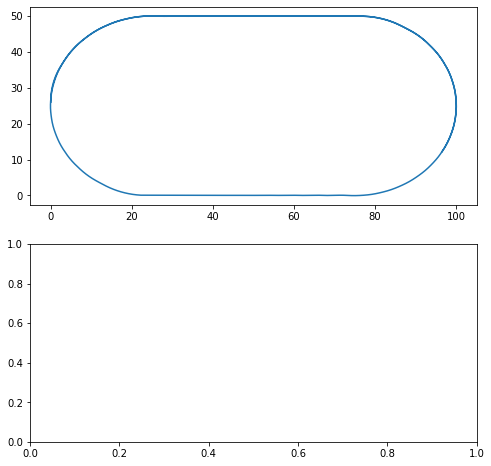

In [30]:
# --------------
# User Instructions
# 
# Define a function cte in the robot class that will
# compute the crosstrack error for a robot on a
# racetrack with a shape as described in the video.
#
# You will need to base your error calculation on
# the robot's location on the track. Remember that 
# the robot will be traveling to the right on the
# upper straight segment and to the left on the lower
# straight segment.
#
# --------------
# Grading Notes
#
# We will be testing your cte function directly by
# calling it with different robot locations and making
# sure that it returns the correct crosstrack error.  
 
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res




    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)


############## ONLY ADD / MODIFY CODE BELOW THIS LINE ####################
   
    def cte(self, radius):
        # 
        #
        # Add code here
        #
        # 
        if self.x < radius:
            cte = sqrt((self.x - radius)**2 + (self.y - radius)**2) - radius
        elif self.x > 3.0*radius:
            cte = sqrt((self.x - 3.0*radius)**2 + (self.y - radius)**2) - radius
        elif self.y > radius:
            cte = self.y - 2.0*radius
        else:
            cte = - self.y
        return cte
    
############## ONLY ADD / MODIFY CODE ABOVE THIS LINE ####################




# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False):
    x_trajectory = []
    y_trajectory = []
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N = 200

    crosstrack_error = myrobot.cte(radius) # You need to define the cte function!

    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = - params[0] * crosstrack_error \
                - params[1] * diff_crosstrack_error \
                - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)
        if i >= N:
            err += crosstrack_error ** 2
        if printflag:
            print(myrobot)
        x_trajectory.append(myrobot.x)
        y_trajectory.append(myrobot.y)
    return x_trajectory, y_trajectory, err / float(N)

radius = 25.0
params = [10.0, 15.0, 0]
x_trajectory, y_trajectory, err = run(params, radius)
print('\nFinal parameters: ', params, '\n ->', err)

n = len(x_trajectory)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, label='PD controller')
